# Magnetometer Calibration

blah ...

## References

- [Teslabs: Magnetometer Calibration](https://teslabs.com/articles/magnetometer-calibration/)
- [ThePoorEngineer: Calibrating the Magnetometer](https://www.thepoorengineer.com/en/calibrating-the-magnetometer/)

In [71]:
import numpy as np # matrix manipulations

from scipy import linalg

import the_collector # read data
print(f"the-collector: {the_collector.__version__}")

from the_collector import BagIt
from the_collector import Pickle, Json

from squaternion import Quaternion

import pandas as pd

%matplotlib inline
from matplotlib import pyplot as plt

# from math import sqrt, atan2, asin, pi
from math import radians as deg2rad
from math import degrees as rad2deg

the-collector: 0.8.5


In [72]:
# import pickle

# with open("data-tumble.pickle.bag","rb") as f:
#     d = f.read()
#     print(len(d))
#     print(type(d))
#     d = pickle.loads(d.encode("utf-8"))

In [2]:
!ls -lh

total 26456
-rw-r--r--  1 kevin  staff   1.6M Jul  6  2019 data-tumble.pickle.bag
-rwx------  1 kevin  staff    11M Apr 20 14:18 imu-1-2.json-gz
-rw-r--r--  1 kevin  staff   140K May  4  2019 imu-rpi.2019-05-04-20:47:18.445193.pickle.bag
-rw-r--r--  1 kevin  staff   294K May  2 21:57 mag-calibrate.ipynb


In [73]:
def bag_info(bag):
    print('Bag keys:')
    print('-'*50)
    for k in bag.keys():
        print(f'  {k:>10}: {len(bag[k]):<7}')

bag = BagIt(Pickle)
# fname = "imu-rpi.2019-05-04-20:47:18.445193.pickle.bag"
# fname = "data-tumble.pickle.bag"
fname = "tumble.pickle.bag"

# bag = the_collector.BagIt(Json)
# bag.packer.compress(True)
# fname = "imu-1-2.json-gz"


data = bag.read(fname)
bag_info(data)

>>  pickle
>> Reading[pickle]: tumble.pickle.bag
Bag keys:
--------------------------------------------------
       accel: 3193   
         mag: 3193   
        gyro: 3193   


In [74]:
# data is an array of IMU messages
def get(bag, key):
    data = {"x":[], "y":[],"z":[],"ts":[]}
    for (x,y,z),ts in bag[key]:
        data["x"].append(x)
        data["y"].append(y)
        data["z"].append(z)
        data["ts"].append(ts)
    return data

def get_np(bag, key):
    xx = []
    yy = []
    zz = []
    for (x,y,z),ts in bag[key]:
        xx.append(x)
        yy.append(y)
        zz.append(z)
    return np.array(xx), np.array(yy), np.array(zz)
#     return np.array([v for v,ts in bag[key]])

# accel = get_np(data, "accel")
# gyro = get_np(data, "gyro")
mag = get_np(data, "mag")

adf = pd.DataFrame(get(data, "accel"))
gdf = pd.DataFrame(get(data, "gyro"))
mdf = pd.DataFrame(get(data, "mag"))

mdf.mean()

x     1.920090e+01
y     1.260626e+01
z     1.135509e+01
ts    1.588533e+09
dtype: float64

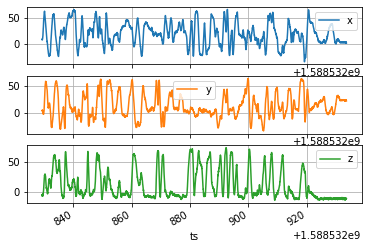

In [75]:
mdf.plot(x="ts", grid=True, subplots=True);

Text(0.5, 0, 'Z')

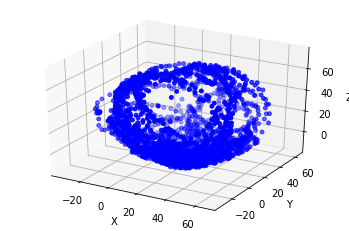

In [76]:
fig1 = plt.figure(1)
ax1 = fig1.add_subplot(111, projection='3d')

ax1.scatter(mag[0], mag[1], mag[2], s=15, color='b')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')

# Save

In [154]:
import sys
import numpy as np
from scipy import linalg

class Magnetometer(object):
    ''' Magnetometer class with calibration capabilities.

        Parameters
        ----------
        sensor : str
            Sensor to use.
        bus : int
            Bus where the sensor is attached.
        F : float (optional)
            Expected earth magnetic field intensity, default=1.
    '''
    def __init__(self, F=1):
        self.F   = F
        self.b   = np.zeros([3, 1])
        self.A_1 = np.eye(3)
    
    def correct(self, s):
        if isinstance(s, list):
            s = np.array(s)
        return np.dot(self.A_1, s - self.b)

    def calibrate(self, s):
        ''' Performs calibration. '''
        s = s.T
        M, n, d = self.__ellipsoid_fit(s)

        # calibration parameters
        # note: some implementations of sqrtm return complex type, taking real
        M_1 = linalg.inv(M)
        self.b = -np.dot(M_1, n).T[0]  # make numpy array [bx,by,bz]
        
        self.A_1 = self.F / np.sqrt(np.abs(np.dot(n.T, np.dot(M_1, n)) - d)) 
        self.A_1 = self.A_1*np.real(linalg.sqrtm(M))
        
#         self.A_1 = np.real(self.F / np.sqrt(np.dot(n.T, np.dot(M_1, n)) - d) *
#                            linalg.sqrtm(M))

    def __ellipsoid_fit(self, s):
        ''' Estimate ellipsoid parameters from a set of points.

            Parameters
            ----------
            s : array_like
              The samples (M,N) where M=3 (x,y,z) and N=number of samples.

            Returns
            -------
            M, n, d : array_like, array_like, float
              The ellipsoid parameters M, n, d.

            References
            ----------
            .. [1] Qingde Li; Griffiths, J.G., "Least squares ellipsoid specific
               fitting," in Geometric Modeling and Processing, 2004.
               Proceedings, vol., no., pp.335-340, 2004
        '''

        # D (samples)
        D = np.array([s[0]**2., s[1]**2., s[2]**2.,
                      2.*s[1]*s[2], 2.*s[0]*s[2], 2.*s[0]*s[1],
                      2.*s[0], 2.*s[1], 2.*s[2], np.ones_like(s[0])])

        # S, S_11, S_12, S_21, S_22 (eq. 11)
        S = np.dot(D, D.T)
        S_11 = S[:6,:6]
        S_12 = S[:6,6:]
        S_21 = S[6:,:6]
        S_22 = S[6:,6:]

        # C (Eq. 8, k=4)
        C = np.array([[-1,  1,  1,  0,  0,  0],
                      [ 1, -1,  1,  0,  0,  0],
                      [ 1,  1, -1,  0,  0,  0],
                      [ 0,  0,  0, -4,  0,  0],
                      [ 0,  0,  0,  0, -4,  0],
                      [ 0,  0,  0,  0,  0, -4]])

        # v_1 (eq. 15, solution)
        E = np.dot(
            linalg.inv(C),
            S_11 - np.dot(S_12, np.dot(linalg.inv(S_22), S_21)))

        E_w, E_v = np.linalg.eig(E)

        v_1 = E_v[:, np.argmax(E_w)]
        if v_1[0] < 0: v_1 = -v_1

        # v_2 (eq. 13, solution)
        v_2 = np.dot(np.dot(-np.linalg.inv(S_22), S_21), v_1)

        # quadric-form parameters
        M = np.array([[v_1[0], v_1[3], v_1[4]],
                      [v_1[3], v_1[1], v_1[5]],
                      [v_1[4], v_1[5], v_1[2]]])
        n = np.array([[v_2[0]],
                      [v_2[1]],
                      [v_2[2]]])
        d = v_2[3]

        return M, n, d

In [155]:
# https://www.ngdc.noaa.gov/geomag/calculators/magcalc.shtml#igrfwmm
# uT
uT = 50.8862
m = Magnetometer(uT) 

In [156]:
def get_list(bag, key):
    d = []
    dt = []
    last = None
    for v,ts in bag[key]:
        d.append(v)
        if last is None:
            last = ts
        else:
            dt.append(ts - last)
            last=ts
    return np.array(d), np.mean(dt)

magg, dt = get_list(data, "mag")
print(f">> {dt:.3f} sec or {1/dt:.1f} Hz")

>> 0.033 sec or 30.6 Hz


In [157]:
m.calibrate(magg)

In [158]:
# """
# [[-0.3985919  -0.0180967  -0.01539174]
#  [-0.0180967  -0.42966123  0.0522018 ]
#  [-0.01539174  0.0522018  -0.80822416]]
# [[ 19.33670483]
#  [-11.646702  ]
#  [-69.15674951]]
# -7455.931326917302
# """
print(m.A_1)
print(m.b)

[[ 1.13607723  0.01426521 -0.01018889]
 [ 0.01426521  1.14363401 -0.00629215]
 [-0.01018889 -0.00629215  1.23403399]]
[20.28337018 16.52551857 29.55239641]


In [159]:
def unit(v):
    x,y,z = v
    n = 1/np.sqrt(x*x + y*y + z*z)
    return (x*n, y*n, z*n,)

orig = []
cm = []
for v in magg:
    mm = m.correct(v)
    cm.append(mm)
    
#     orig.append(unit(v))
    orig.append(v)

Text(0.5, 0, 'Z')

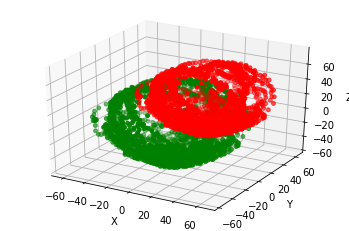

In [163]:
fig1 = plt.figure(1)
ax1 = fig1.add_subplot(111, projection='3d')

ax1.scatter([x[0] for x in cm],[x[1] for x in cm],[x[2] for x in cm], s=15, color='g')
ax1.scatter([x[0] for x in orig],[x[1] for x in orig],[x[2] for x in orig], s=15, color='r')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
# plot unit sphere
# u = np.linspace(0, 2 * np.pi, 100)
# v = np.linspace(0, np.pi, 100)
# x = np.outer(np.cos(u), np.sin(v))
# y = np.outer(np.sin(u), np.sin(v))
# z = np.outer(np.ones(np.size(u)), np.cos(v))
# ax1.plot_wireframe(x, y, z, rstride=10, cstride=10, alpha=0.5)
# ax1.plot_surface(x, y, z, alpha=0.3, color='b');

In [161]:
error = 0
for v in cm:
    error += np.linalg.norm(v)-uT
print(error/len(cm))

-0.005550813792737799


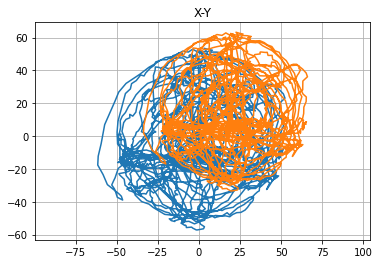

In [162]:
plt.plot([x[0] for x in cm], [x[1] for x in cm])
plt.plot([x[0] for x in orig], [x[1] for x in orig])
plt.axis('equal')
plt.title("X-Y")
plt.grid(True)

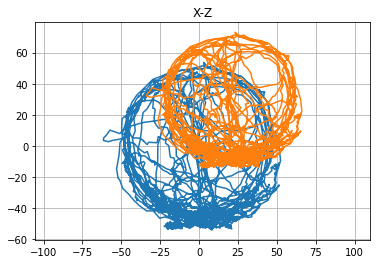

In [146]:
plt.plot([x[0] for x in cm], [x[2] for x in cm])
plt.plot([x[0] for x in orig], [x[2] for x in orig])
plt.axis('equal')
plt.title("X-Z")
plt.grid(True)

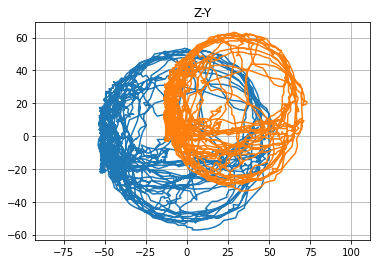

In [147]:
plt.plot([x[2] for x in cm], [x[1] for x in cm])
plt.plot([x[2] for x in orig], [x[1] for x in orig])
plt.axis('equal')
plt.title("Z-Y")
plt.grid(True)

In [148]:
A=m.A_1
b=m.b

In [149]:
ans=(np.dot(A,(magg-b).T)).T

In [151]:
error = 0
for v in ans:
    error += np.linalg.norm(v)-uT
print(error/len(ans))

-0.00555081379273808


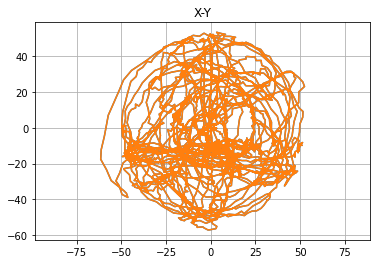

In [152]:
plt.plot([x[0] for x in cm], [x[1] for x in cm])
plt.plot([x[0] for x in ans], [x[1] for x in ans])
plt.axis('equal')
plt.title("X-Y")
plt.grid(True)

In [153]:
ans.shape

(3193, 3)